In [1]:
import modelling_lib_rodrixx as mod
import preprocessing_lib_rodrixx as prep

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

import mlflow

In [2]:
dataframes_path = os.path.join(os.getcwd(), 'dataframes')
csv_path = os.path.join(os.getcwd(), 'column_csv')

In [3]:
df = pd.read_pickle(os.path.join(dataframes_path, 'stats_1980_to_2021.pkl'))

In [4]:
df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP_pg,FG_pg,FGA_pg,...,DBPM_rank,BPM_rank,VORP_rank,%W,GT,%W_rank,%G,Votes,Share,MaxVotes
0,1,Kareem Abdul-Jabbar,C,32,LAL,82,-10,38.3,10.2,16.9,...,7,2,1,0.732,82,2,1.000,147,0.665,221
1,2,Tom Abernethy,PF,25,GSW,67,-10,18.2,2.3,4.7,...,32,54,41,0.293,82,44,0.817,0,0.000,221
2,3,Alvan Adams,C,25,PHO,75,-10,28.9,6.2,11.7,...,11,12,12,0.671,82,6,0.915,0,0.000,221
3,4,Tiny Archibald,PG,31,BOS,80,80,35.8,4.8,9.9,...,33,31,20,0.744,82,1,0.976,2,0.009,221
4,5,Dennis Awtrey,C,31,CHI,26,-10,21.5,1.0,2.3,...,21,56,42,0.366,82,38,0.317,0,0.000,221


In [5]:
cols_to_drop = ['Rk', 'GT', 'Votes', 'MaxVotes', 'FG_tot', '3PA_tot', '2PA_tot', 'FGA_rank_tot', 'Tm', 'Pos']
cols_to_filter = ['PER', 'WS/48', 'BPM', 'USG%']
cols_to_ohe = ['Pos', 'Tm']

In [6]:
pipe_clean = Pipeline(steps = [
    ('DropPlayersMultiTeams', prep.DropPlayersMultiTeams()),
    ('OutlierFilter', prep.OutlierFilter(q = .0005, col_to_filter = cols_to_filter)),
    ('SetIndex', prep.SetIndex()),
    ('DropColumns', prep.DropColumns(cols_to_drop)),
    ('DropPlayers', prep.DropPlayers()),
])

In [7]:
df = pipe_clean.fit_transform(df)

In [8]:
df.head()

,,Age,G,GS,MP_pg,FG_pg,FGA_pg,FG%,3P_pg,3PA_pg,3P%,...,WS_rank,WS/48_rank,OBPM_rank,DBPM_rank,BPM_rank,VORP_rank,%W,%W_rank,%G,Share
Rk,Season,,,,,,,,,,,,,,,,,,,,,
1,1980,32,82,-10,38.3,10.2,16.9,0.604,0.0,0.0,0.000,...,1,1,5,7,2,1,0.732,2,1.000,0.665
2,1980,25,67,-10,18.2,2.3,4.7,0.481,0.0,0.0,0.000,...,71,83,50,32,54,41,0.293,44,0.817,0.000
3,1980,25,75,-10,28.9,6.2,11.7,0.531,0.0,0.0,0.000,...,27,21,23,11,12,12,0.671,6,0.915,0.000
4,1980,31,80,80,35.8,4.8,9.9,0.482,0.1,0.2,0.222,...,14,25,26,33,31,20,0.744,1,0.976,0.009
5,1980,31,26,-10,21.5,1.0,2.3,0.450,0.0,0.0,0.000,...,85,109,63,21,56,42,0.366,38,0.317,0.000


In [9]:
len(df[df.index.get_level_values(1) > 2015]) / len(df)

0.17507805847289243

In [10]:
val_df = df[df.index.get_level_values(1) > 2015]
dev_df = df[df.index.get_level_values(1) <= 2015]

In [11]:
dev_df, sampling_ratio = mod.oversample(dev_df, os_param = 'smote', sampling_strategy = .35)

In [12]:
X_train = dev_df.drop('Share', axis=1)
y_train = dev_df[['Share']]

X_val = val_df.drop('Share', axis=1)
y_val = val_df[['Share']]

In [13]:
scaler = MinMaxScaler()
scaler.fit(pd.concat([X_train, X_val], ignore_index = True))

MinMaxScaler()

In [14]:
datasets = {'train': X_train, 'val': X_val}
real_targets = {'train': y_train, 'val': y_val}

In [15]:
# pipe_scale = Pipeline(steps = [
#     ('Scaler', scaler),
#     ('ArrayToDf', prep.ArrayToDataFrame(columns = X_train.columns))
# ])

In [16]:
# for key, dataset in datasets.items():
#     index_param = dataset.index
#     pipe_scale.set_params(**{'ArrayToDf__index': index_param})
#     datasets[key] = pipe_scale.transform(dataset)

In [17]:
mlflow.set_experiment('NBA MVP prediction Random Forest')

<Experiment: artifact_location='file:///C:/Users/marcr/OneDrive/Documents/Data%20Science/NBA%20Project/mlruns/4', experiment_id='4', lifecycle_stage='active', name='NBA MVP prediction Random Forest', tags={}>

In [18]:
param_grid = {
    'max_depth': [3], 
    'min_samples_split': [10],
    'max_features': [.8],
    'n_estimators': [100]
    }

In [19]:
with mlflow.start_run():
    estimator = RandomForestRegressor(random_state = 23)

    model = GridSearchCV(estimator, param_grid, scoring = ('neg_root_mean_squared_error', 'r2'), refit = 'neg_root_mean_squared_error', cv = 10, verbose = 2)

    model.fit(X_train, y_train)

    results = model.cv_results_

    cv_scores = mod.get_cv_scores(results)

    best_model, best_params, best_cv_score = mod.retrieve_best(model)

    predicted_targets = mod.predict_model(best_model, datasets)

    mod.log_sampling_ratio_mlflow(sampling_ratio)

    mod.log_params_mlflow_rf(best_params)

    mod.log_metrics_mlflow(real_targets, predicted_targets, cv_scores)

    mod.log_advanced_metrics_mlflow(real_targets['val'], predicted_targets['val'])

    mod.log_model_mlflow(best_model)

    mod.log_features_mlflow(X_train, csv_path)

    mod.log_important_features_mlflow(mod.display_feature_importances(best_model))

    mod.log_val_results_mlflow(*mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list_))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END max_depth=3, max_features=0.8, min_samples_split=10, n_estimators=100; total time= 2.1min
[CV] END max_depth=3, max_features=0.8, min_samples_split=10, n_estimators=100; total time= 2.1min
[CV] END max_depth=3, max_features=0.8, min_samples_split=10, n_estimators=100; total time=  41.4s
[CV] END max_depth=3, max_features=0.8, min_samples_split=10, n_estimators=100; total time=  37.6s
[CV] END max_depth=3, max_features=0.8, min_samples_split=10, n_estimators=100; total time=  38.6s
[CV] END max_depth=3, max_features=0.8, min_samples_split=10, n_estimators=100; total time=  37.2s
[CV] END max_depth=3, max_features=0.8, min_samples_split=10, n_estimators=100; total time=  36.9s
[CV] END max_depth=3, max_features=0.8, min_samples_split=10, n_estimators=100; total time=  37.1s
[CV] END max_depth=3, max_features=0.8, min_samples_split=10, n_estimators=100; total time=  36.1s
[CV] END max_depth=3, max_features=0.8, min_samp

2022/07/31 22:17:08 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\marcr\AppData\Local\Temp\tmpwetnmkue\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.


In [20]:
mod.display_metrics(real_targets, predicted_targets, cv_scores)

,Train,CV,Validation
RMSE,0.065109,0.055828,0.035692
R2,0.748560,0.669529,0.602161


In [21]:
contenders_df, no_contenders_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list_)

In [22]:
mod.display_val_results(contenders_df, no_contenders_df)

Contenders Results:


,,Player,Share,PredShare
Rk,Season,,,
105,2016,Stephen Curry,1.000,0.832223
263,2016,Kawhi Leonard,0.484,0.241372
222,2016,LeBron James,0.482,0.202465
452,2016,Russell Westbrook,0.371,0.333042
126,2016,Kevin Durant,0.112,0.418640
348,2016,Chris Paul,0.082,0.137417
167,2016,Draymond Green,0.038,0.072036
266,2016,Damian Lillard,0.020,0.073746
178,2016,James Harden,0.007,0.162626


,,Player,Share,PredShare
Rk,Season,,,
458,2017,Russell Westbrook,0.879,0.203316
173,2017,James Harden,0.746,0.460282
261,2017,Kawhi Leonard,0.495,0.277326
221,2017,LeBron James,0.330,0.198287
425,2017,Isaiah Thomas,0.080,0.169459
98,2017,Stephen Curry,0.051,0.133926
16,2017,Giannis Antetokounmpo,0.007,0.147882
453,2017,John Wall,0.007,0.118677
100,2017,Anthony Davis,0.002,0.170962


,,Player,Share,PredShare
Rk,Season,,,
195,2018,James Harden,0.955,0.663428
249,2018,LeBron James,0.731,0.360682
122,2018,Anthony Davis,0.441,0.331938
298,2018,Damian Lillard,0.205,0.225406
508,2018,Russell Westbrook,0.075,0.165136
16,2018,Giannis Antetokounmpo,0.074,0.168294
143,2018,Kevin Durant,0.065,0.152917
130,2018,DeMar DeRozan,0.032,0.024670
7,2018,LaMarcus Aldridge,0.006,0.052056


,,Player,Share,PredShare
Rk,Season,,,
18,2019,Giannis Antetokounmpo,0.932,0.434487
207,2019,James Harden,0.768,0.512468
184,2019,Paul George,0.352,0.206849
270,2019,Nikola Jokić,0.210,0.137786
124,2019,Stephen Curry,0.173,0.133584
305,2019,Damian Lillard,0.068,0.252721
155,2019,Joel Embiid,0.049,0.053740
150,2019,Kevin Durant,0.025,0.155001
301,2019,Kawhi Leonard,0.013,0.149796


,,Player,Share,PredShare
Rk,Season,,,
13,2020,Giannis Antetokounmpo,0.952,0.411204
251,2020,LeBron James,0.746,0.172522
199,2020,James Harden,0.363,0.449028
134,2020,Luka Dončić,0.198,0.169691
294,2020,Kawhi Leonard,0.166,0.147953
123,2020,Anthony Davis,0.081,0.308703
396,2020,Chris Paul,0.026,0.034568
297,2020,Damian Lillard,0.023,0.283377
262,2020,Nikola Jokić,0.018,0.119358


,,Player,Share,PredShare
Rk,Season,,,
263,2021,Nikola Jokić,0.961,0.559220
146,2021,Joel Embiid,0.580,0.067919
116,2021,Stephen Curry,0.449,0.179237
12,2021,Giannis Antetokounmpo,0.345,0.273314
396,2021,Chris Paul,0.138,0.022087
130,2021,Luka Dončić,0.042,0.150811
297,2021,Damian Lillard,0.038,0.285938
421,2021,Julius Randle,0.020,0.019591
439,2021,Derrick Rose,0.010,0.001617


No contenders results:


,,Player,Share,PredShare
Rk,Season,,,
1,2016,Quincy Acy,0.0,0.001617
2,2016,Jordan Adams,0.0,0.001617
3,2016,Steven Adams,0.0,0.001617
4,2016,Arron Afflalo,0.0,0.001617
5,2016,Alexis Ajinça,0.0,0.001617
...,...,...,...,...
536,2021,Delon Wright,0.0,0.001617
537,2021,Thaddeus Young,0.0,0.002235
538,2021,Trae Young,0.0,0.038437


In [23]:
no_contenders_df[no_contenders_df['PredShare'] > 0.1]

,,Player,Share,PredShare
Rk,Season,,,
66,2017,Jimmy Butler,0.0,0.284948
87,2017,Mike Conley,0.0,0.107336
90,2017,DeMarcus Cousins,0.0,0.151864
156,2017,Rudy Gobert,0.0,0.218411
234,2017,Nikola Jokić,0.0,0.127915
266,2017,Damian Lillard,0.0,0.119771
351,2017,Chris Paul,0.0,0.125878
434,2017,Karl-Anthony Towns,0.0,0.166461
240,2018,Kyrie Irving,0.0,0.121509


<AxesSubplot:title={'center':'Most important features'}, xlabel='Feature', ylabel='Linear coefficient'>

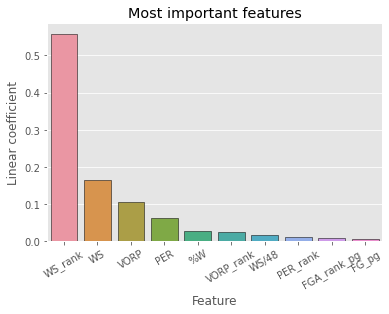

In [24]:
mod.display_feature_importances(best_model)

In [25]:
cont_df, no_cont_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list_)

(<Figure size 2880x2880 with 6 Axes>, <Figure size 2880x2880 with 6 Axes>)

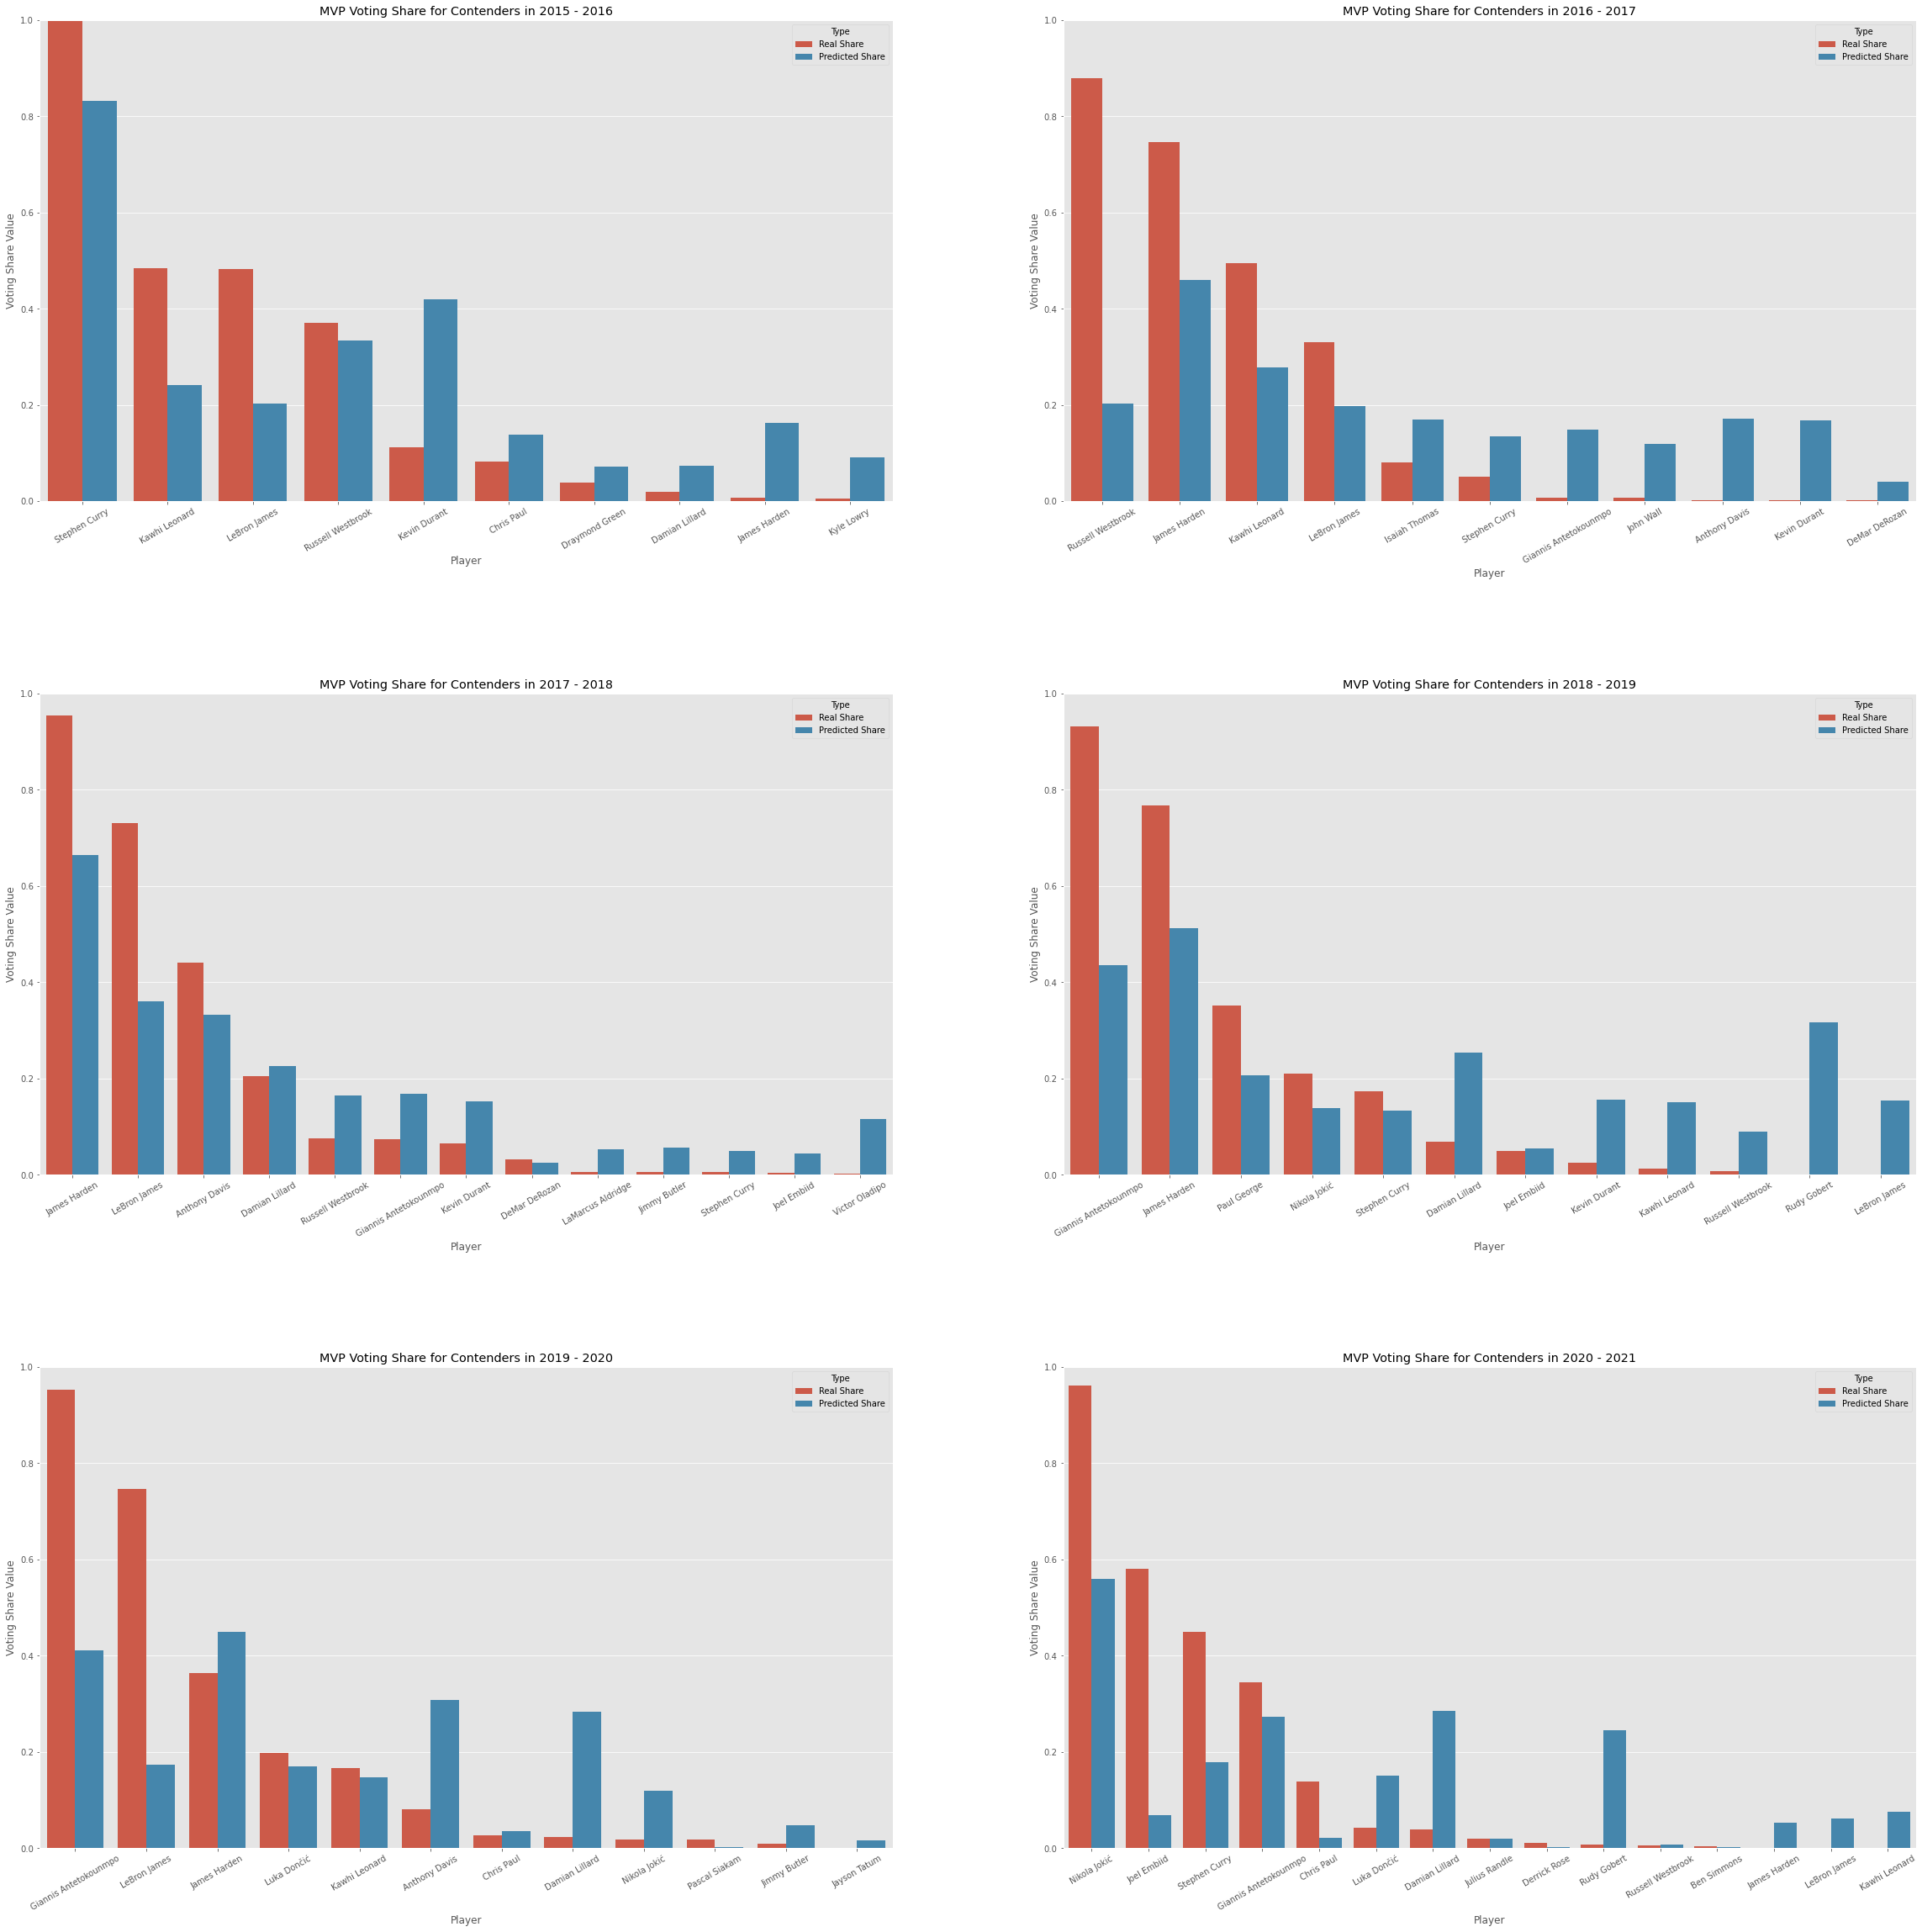

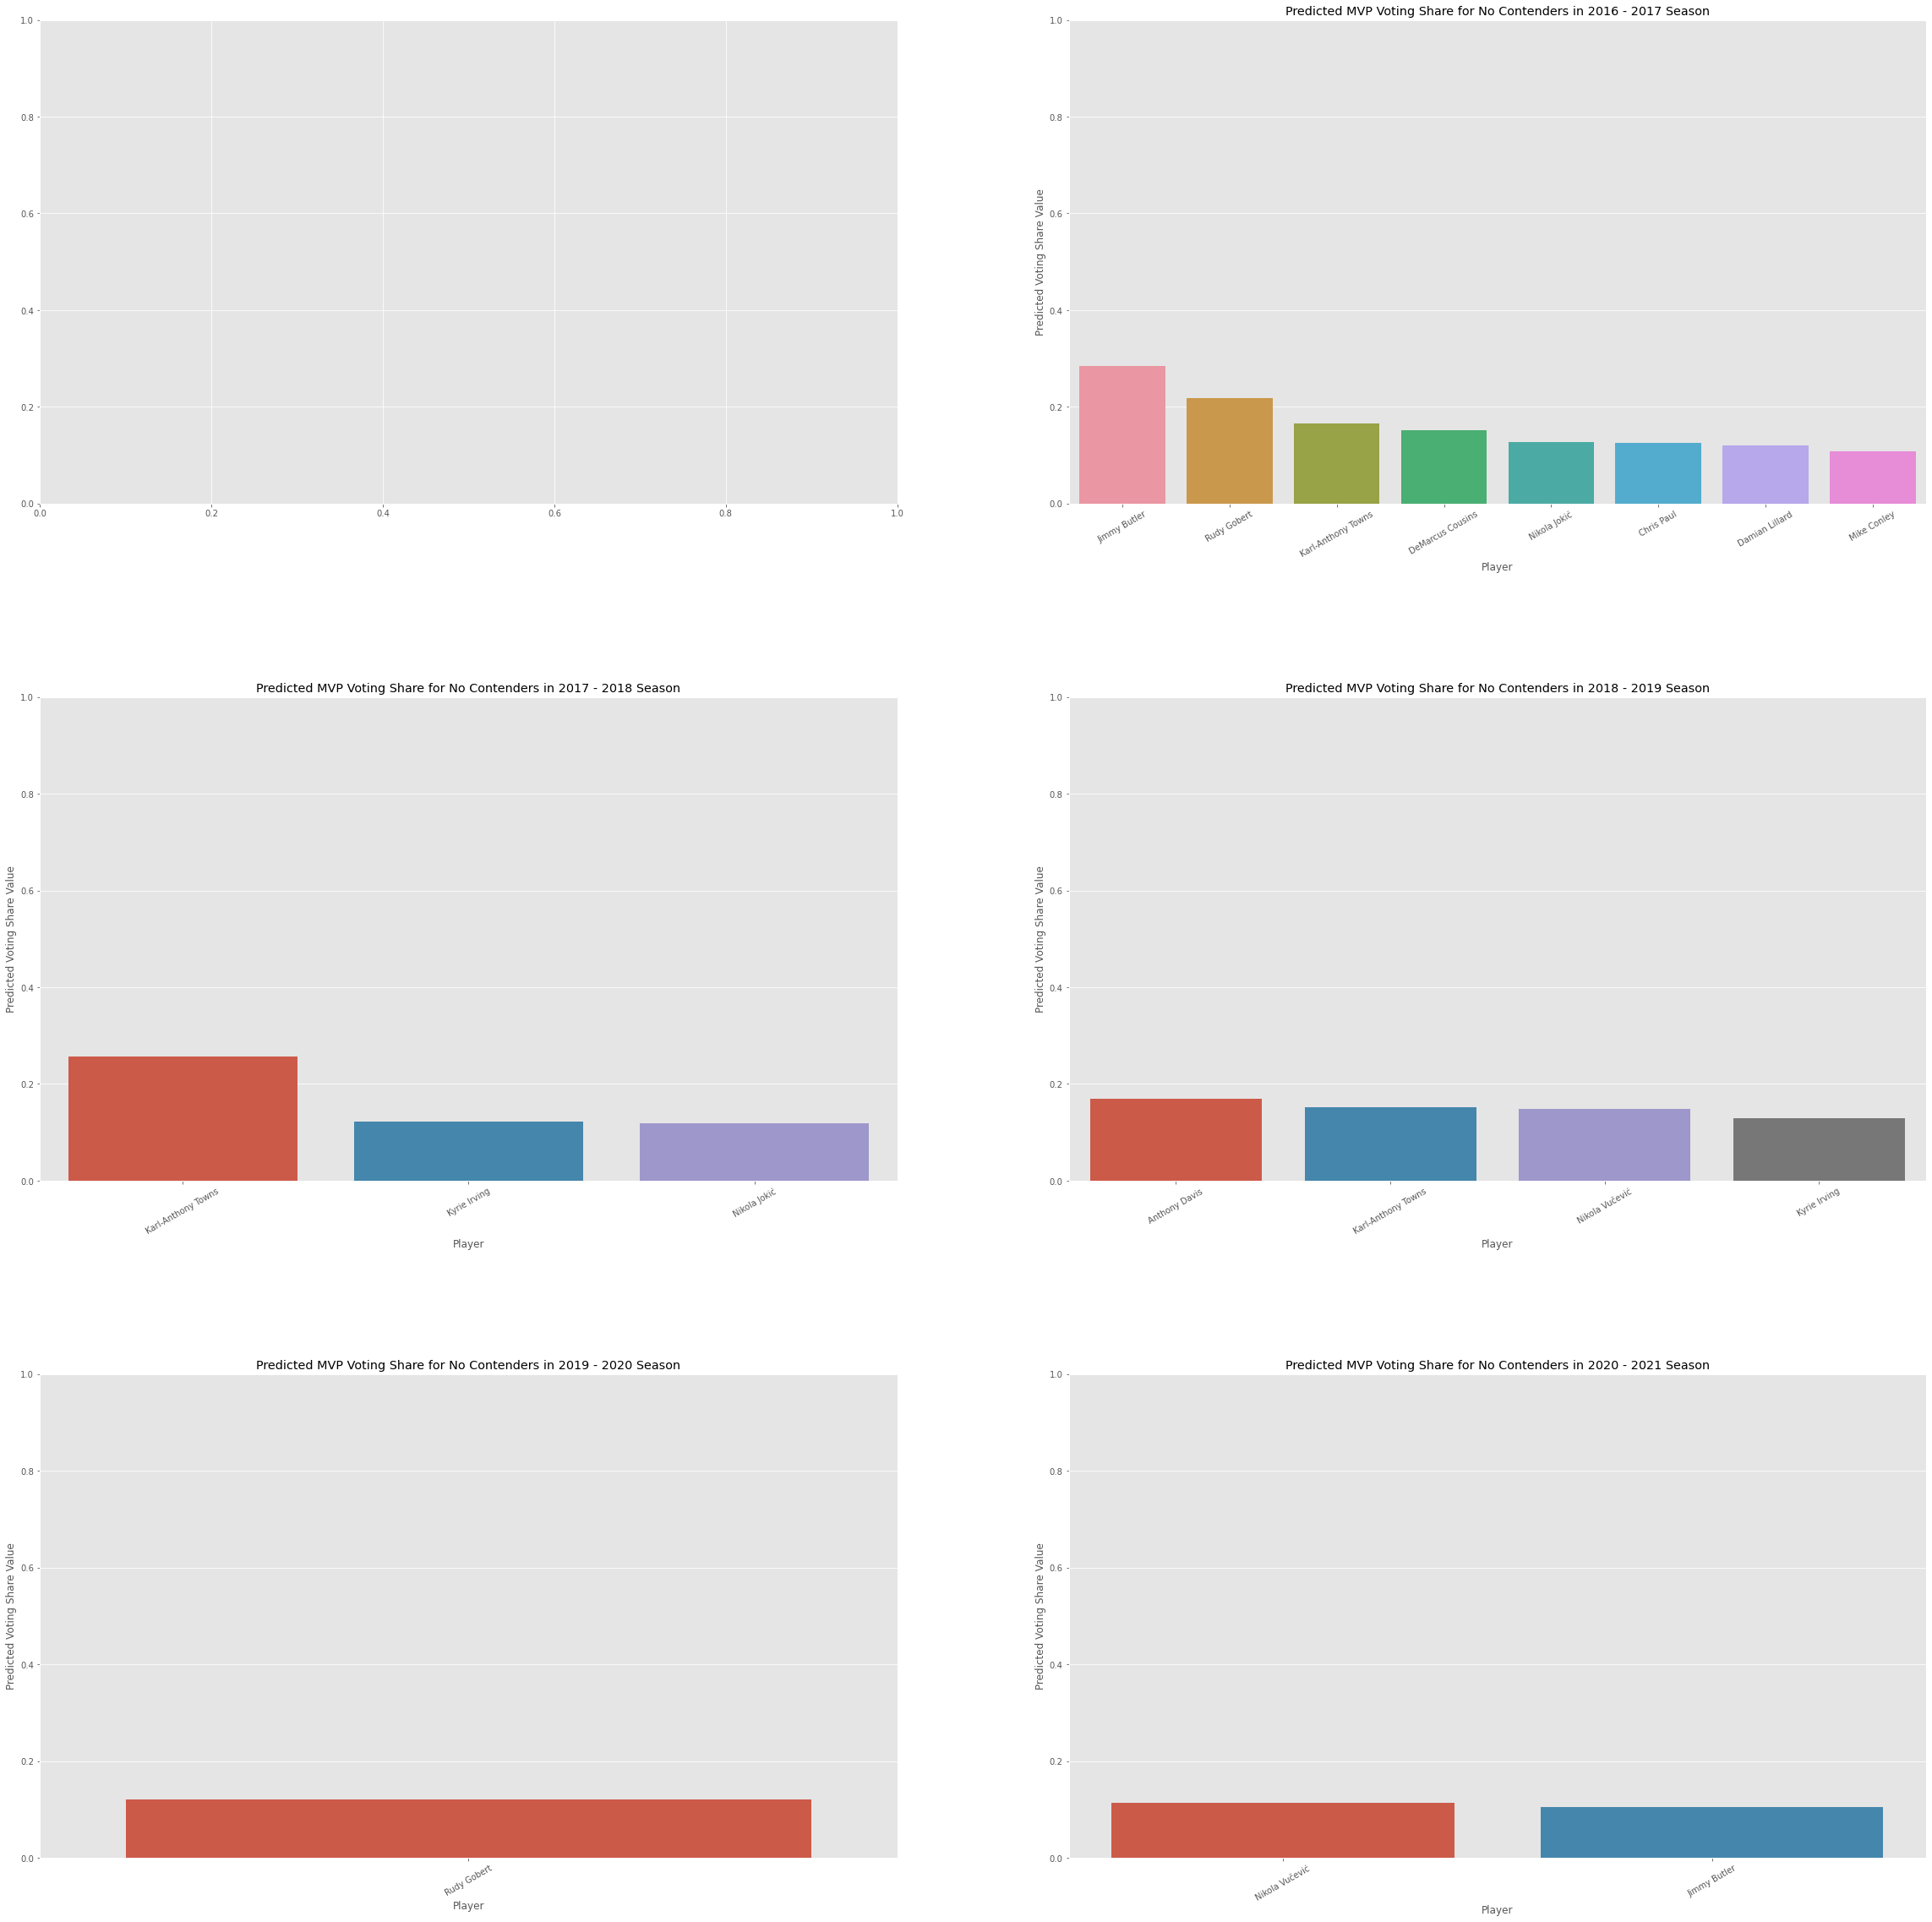

In [26]:
mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list_)